------
# Help Function

In previous notebook, we use `pyspark` to get all the nodes and links in the whole `IMDB` website, and use a package called `graphframes` to build this super gigiant bipartite network, which has 1,053,777 nodes and 1,213,746 links.

Graphframes still has limited funtions to processing graph, we try to use networkx or other graph packages to handle it.

In [6]:
import os
import sys
import powerlaw
import pickle
import numpy as np
import pandas as pd 
import networkx as nx
import igraph as ig
import graph_tool.all as gt 
from collections import Counter
from bidict import bidict
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm
from SN_help import build_bipartite, dict2np, draw_degree_dist_timely, draw_degree_distributions_bar, draw_powerlaws

# IMDB Actor-Moive Bipartite Network

We use different graph packages, which is `Graph Tool`, `iGraph` and `NetworkX`, to build our bipartite network, and do some comparison.

1. `Graph Tool` runs really fast, but hard to use ⭐️⭐️.
2. `iGraph` runs fast, and have a good balance of practicality and performance, and the best part is it can fit power-law exponent😊⭐️⭐️⭐️⭐️.
3. `NetworkX` is a universal graph tool, full-featured 😄⭐️⭐️⭐️.

In [7]:
movie_path = './imdb/movie_basic.parquet'
actor_path = './imdb/actor_basic.parquet'
link_path = './imdb/movie_actor_basic.parquet'
save_path = './imdb/network'
tag = 'imdb'
mg, ag, mgcc, agcc = build_bipartite(movie_path, actor_path, link_path, save_path, tag)

>>>> Adding 627833 movies and 426018 actors to network.
>>>> Adding 1213746 movie-actor links to network.
>>>> Projecting bipartite nework to movie nodes and actor nodes.
>>>> Cleanning useless attributes for Movie Network.
		['bipartite', 'birthYear', 'deathYear', 'nconst', 'primaryName']
>>>> Cleanning useless attributes for Actor Network.
		['bipartite', 'description', 'genres', 'averageRating', 'numVotes', 'primaryTitle', 'runtimeMinutes', 'startYear', 'tconst']
		There is no description attribute, pass
>>>> Getting the GCC of Movie Network and Actor Network.
		Movie: (N627833, L16230951)-->(N362943, L16206831)
		Actor: (N426018, L1268202)-->(N274067, L1091586)
>>>> Saving to ./imdb/network/imdb.movie.ig.pickle and ./imdb/network/imdb.actor.ig.pickle
>>>> Summary:
IGRAPH U-W- 627833 16230951 -- 
+ attr: averageRating (v), genres (v), numVotes (v), primaryTitle (v), runtimeMinutes (v), startYear (v), tconst (v), weight (e)
IGRAPH U-W- 426018 1268202 -- 
+ attr: birthYear (v), deathY

# IMDB Movie Network

`mg` is short for movie graph, `er` for Erdős–Rényi, `ba` for Barabasi-Albert

## Basic Data Analysis

In [8]:
mN, mL = len(mg.vs), len(mg.es)
density = mg.density()
print(f'Nodes: {mN}\nLinks: {mL}\nDensity: {density}')
print('Summary: ', mg.summary())

Nodes: 627833
Links: 16230951
Density: 8.235431810344703e-05
Summary:  IGRAPH U-W- 627833 16230951 -- 
+ attr: averageRating (v), genres (v), numVotes (v), primaryTitle (v), runtimeMinutes (v), startYear (v), tconst (v), weight (e)


In [9]:
# Load Checkpoint
# mg = ig.Graph.Read_Pickle('./imdb/network/imdb.movie.ig.pickle')
# Print summary
mg = mg.connected_components().giant()
mN, mL = len(mg.vs), len(mg.es)
density = mg.density()
print(f'Nodes: {mN}\nLinks: {mL}\nDensity: {density}')
print('Summary: ', mg.summary())

Nodes: 362943
Links: 16206831
Density: 0.0002460664741438986
Summary:  IGRAPH U-W- 362943 16206831 -- 
+ attr: averageRating (v), genres (v), numVotes (v), primaryTitle (v), runtimeMinutes (v), startYear (v), tconst (v), weight (e)


## Degree Distribution

Calculating best minimal value for power law fit
2.9914069311387337
Calculating best minimal value for power law fit
8.093270078883238%
Calculating best minimal value for power law fit
5.053434486335963%


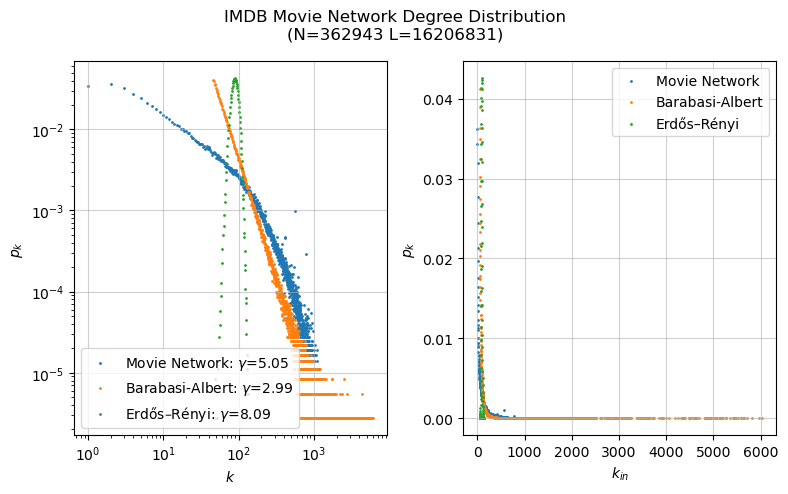

In [34]:
# generate a BA network
ba = ig.Graph.Barabasi(mN, 46)
ba_gamma = powerlaw.Fit(ba.degree(), discrete=True).alpha
print(ba_gamma)
ba_dist = Counter(ba.degree())

# generate a random network
er = ig.Graph.Erdos_Renyi(n=mN, m=mL, directed=False, loops=False)
er_gamma = powerlaw.Fit(er.degree(), discrete=True).alpha
print(er_gamma)
er_dist = Counter(er.degree())

# get the GCC of projected movie network
mg_gamma = powerlaw.Fit(mg.degree(), discrete=True).alpha
print(mg_gamma)
mg_dist = Counter(mg.degree())

# draw_degree_distribution(dict2np(m_dist), mn, 'IMDB Movie', f'Movie $\gamma$={model.alpha:.2f}')
dists = [dict2np(mg_dist), dict2np(ba_dist), dict2np(er_dist)]
gammas = [mg_gamma, ba_gamma, er_gamma] 
tags = ['Movie Network', 'Barabasi-Albert', 'Erdős–Rényi']
draw_degree_distributions(dists, gammas, mN, mL, tags, 'IMDB')

## Network Growing

In [35]:
first_year = min(mg.vs['startYear'])
last_year = max(mg.vs['startYear'])

first_movie = mg.vs.select(startYear_eq = first_year)['primaryTitle']
last_movie = mg.vs.select(startYear_eq = last_year)['primaryTitle']
print(f'The first movie in our full-connected network is {first_movie} in {first_year}, and the newest is {last_movie}, will be released in {last_year}')

The first movie in our full-connected network is ['Miss Jerry'] in 1894.0, and the newest is ['Avatar 5'], will be released in 2028.0


### Static display

Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


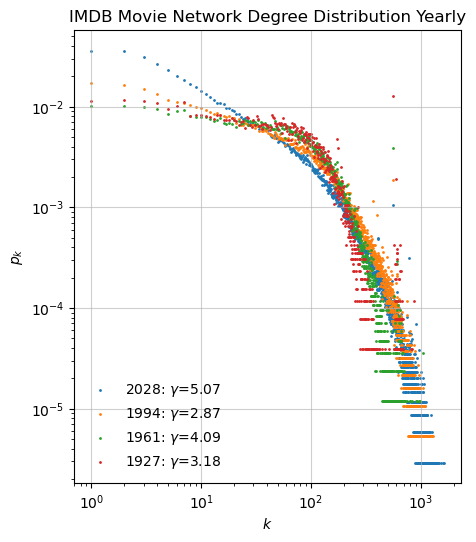

In [37]:
# 1894, 1927, 1961, 1994, 2028
years = [1927, 1961, 1994, 2028]
def get_degree_dist_before(G, year):
    sub_vs = G.vs.select(startYear_le = year)
    sub_g = G.subgraph(sub_vs[:])
    sub_gamma = powerlaw.Fit(sub_g.degree(), discrete=True).alpha
    sub_dist = dict2np(Counter(sub_g.degree()))
    return sub_dist, sub_gamma, len(sub_vs)

dists = []
gammas = []
Ns = []
for year in years:
    sub_dist, sub_gamma, N = get_degree_dist_before(mg, year)
    dists.append(sub_dist)
    gammas.append(sub_gamma)
    Ns.append(N)

draw_degree_dist_timely(dists, gammas, Ns, years, 'IMDB Movie Network')

### Dynamic display

In [39]:
%matplotlib inline
import matplotlib.animation as animation
from IPython import display
plt.ioff()
plt.rcParams['animation.ffmpeg_path'] = '/opt/homebrew/Cellar/ffmpeg/5.1.2/bin/ffmpeg' # change to your ffmpeg path

fig, ax = plt.subplots(figsize=(5,6), dpi=100)
txt_title = ax.set_title('')
# txt_label = plt.legend(loc='lower left')
ax.set_xlabel('$k_{in}$')
ax.set_ylabel('$p_k$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1, 2000)
ax.set_ylim(10e-7, 1)
ax.grid(alpha=0.6)
xdata, ydata = [], []
ln, = ax.plot([], [], 'g.', ms=3)
        
def update(year):
    sub_vs = mg.vs.select(startYear_le = year)
    sub_g = mg.subgraph(sub_vs)
    sub_dist = dict2np(Counter(sub_g.degree()))
    xdata = sub_dist[:,0]
    ydata = sub_dist[:,1] / len(sub_vs)
    ln.set_data(xdata, ydata)  
    txt_title.set_text(f'Evolution of Degree in IMDB Movies\n(Y:{year} N:{len(sub_vs)})')
    # txt_label.get_texts()[0].set_text(year)
    return ln,

years = range(1927, 2028, 1)
anim = animation.FuncAnimation(fig, update, years, blit=True)
video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close() 

## ~Shortest-path-length Distribution~

In [ ]:
# mg_length_hist = mg.path_length_hist(directed=False)
# ba_length_hist = ba.path_length_hist(directed=False)
# er_length_hist = er.path_length_hist(directed=False)

## Summary 

In [401]:
summary = pd.DataFrame(np.ones((3,8)), columns = ['Network', 'N', 'L', '⟨k⟩', '⟨k²⟩', 'σ', 'γ', 'Density'])
summary.Network = ['Movie-Network', 'Barabási–Albert', 'Erdős–Rényi']
summary.N = [len(mg.vs), len(ba.vs), len(er.vs)]
summary.L = [len(mg.es), len(ba.es), len(er.es)]
summary.loc[:, '⟨k⟩']  = [np.mean(i) for i in [mg.degree(), ba.degree(), er.degree()]]
summary.loc[:, '⟨k²⟩'] = [np.square(i).mean() for i in [mg.degree(), ba.degree(), er.degree()]]
summary.loc[:, 'σ'] = [np.std(mg.degree()), np.std(ba.degree()), np.std(er.degree())]
summary.loc[:, 'γ'] = [mg_gamma, ba_gamma, er_gamma]
summary.loc[:, '⟨d⟩'] = [None] * 3
summary.Density = [mg.density(), ba.density(), er.density()]  
# summary.Diameter = [mg.diameter(directed=False), ba.diameter(False), er.diameter(Fales)]   # 'Diameter'
summary

,Network,N,L,⟨k⟩,⟨k²⟩,σ,γ,Density,⟨d⟩
0,Movie-Network,362943,16206831,89.307858,24599.352774,128.931995,5.053434,0.000246,None
1,Barabási–Albert,362943,16694297,91.994043,23647.351375,123.225190,2.980008,0.000253,None
2,Erdős–Rényi,362943,16206831,89.307858,8065.342371,9.457739,8.095757,0.000246,None


In [385]:
np.std(mg.degree()), np.std(ba.degree()), np.std(er.degree())

(128.93199458489858, 14.131975897426685, 9.463880540681448)

## ~Centrality~

- `Degree Centrality`: *Important nodes will have a much higher degree*

    $C_{d e g}(v)=\frac{d_v}{|N|-1}$, where $N$ is the set of nodes in the network and $d_v$ is the degree of node $v$.
    

- `Clossness Centrality`: *Important nodes will be closer to other nodes*

    $C_{\text {close }}(v)=\frac{|N|-1}{\sum_{u \in N \backslash\{v\}} d(v, u)}$, where
    $N=$ set of nodes in the network,
    $d(v, u)=$ length of shortest path from $v$ to $u$.

- `Betweenness Centrality`: *Important nodes will have many shortest paths that pass through*

    $C_{b t w}(v)=\sum_{s, t \in N} \frac{\sigma_{s, t}(v)_o}{\sigma_{s, t}}$, where
    $\sigma_{s, t}=$ the number of shortest paths between nodes $s$ and $t$.
    $\sigma_{s, t}(v)=$ the number shortest paths between nodes $s$ and $t$ that pass through node $v$.
    
- `Eigenvector Centrality`: **

    Google's `PageRank` and `Katz` centrality are variants of Eigenvector centrality.

In [ ]:
# degree_c = np.array(mg.degree()) / np.array(mg.degree()).max()
# closeness_c = mg.closeness(mode='in')
# betweenness_c = mg.betweenness(directed=False)
# eigenvector_c = mg.eigenvector_centrality(directed=False)

# IMDB Actor Network

In [40]:
# Load Checkpoint
# ag = ig.Graph.Read_Pickle('./imdb/network/imdb.actor.ig.pickle')
# Print summary
ag = ag.connected_components().giant()
aN, aL = len(ag.vs), len(ag.es)
density = ag.density()
print(f'Nodes: {aN}\nLinks: {aL}\nDensity: {density}')
print('Summary: ', mg.summary())

Nodes: 274067
Links: 1091586
Density: 2.9065382689500064e-05
Summary:  IGRAPH U-W- 362943 16206831 -- 
+ attr: averageRating (v), bipartite (v), birthYear (v), deathYear (v), genres (v), nconst (v), numVotes (v), primaryName (v), primaryTitle (v), runtimeMinutes (v), startYear (v), tconst (v), weight (e)


Calculating best minimal value for power law fit
3.1509743479113883


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
11.344265140835686
Calculating best minimal value for power law fit
2.2341629949289263


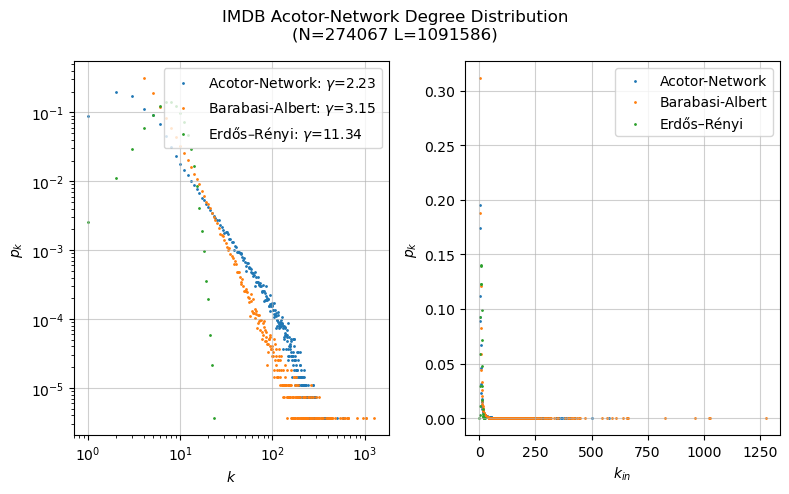

In [41]:
# generate a BA network
ba = ig.Graph.Barabasi(aN, 4)
ba_gamma = powerlaw.Fit(ba.degree(), discrete=True).alpha
print(ba_gamma)
ba_dist = Counter(ba.degree())

# generate a random network
er = ig.Graph.Erdos_Renyi(n=aN, m=aL, directed=False, loops=False)
er_gamma = powerlaw.Fit(er.degree(), discrete=True).alpha
print(er_gamma)
er_dist = Counter(er.degree())

# get the GCC of projected movie network
ag_gamma = powerlaw.Fit(ag.degree(), discrete=True).alpha
print(ag_gamma)
ag_dist = Counter(ag.degree())

# draw_degree_distribution(dict2np(m_dist), mn, 'IMDB Actor', f'Movie $\gamma$={model.alpha:.2f}')
dists = [dict2np(ag_dist), dict2np(ba_dist), dict2np(er_dist)]
gammas = [ag_gamma, ba_gamma, er_gamma] 
tags = ['Acotor-Network', 'Barabasi-Albert', 'Erdős–Rényi']
draw_degree_distributions(dists, gammas, aN, aL, tags, 'IMDB')

## Network Growing

*Use `birthYear` is not a good idea to track the growing of the network, but we still can observe some valid information*

*Only 78419 actors have birth year information, and 195648 actors haven't, and the $\gamma \approx 7$ we fitted is not the case of the whole network .*

In [46]:
first_birth = np.nanmin(ag.vs['birthYear']) # uncleaned data in IMDB, 1830 years, actually
last_birth = np.nanmax(ag.vs['birthYear'])

first_actor = ag.vs.select(birthYear_eq = first_birth)['primaryName']
last_actor = ag.vs.select(birthYear_eq = last_birth)['primaryName']
print(f'{first_actor} was born in {first_birth}, \
and the youngest is {last_actor}, born in {last_birth}')

count = 0
for i in ag.vs[:]['birthYear']:
    if np.isnan(i):
        count += 1
count_valid = len(ag.vs.select(birthYear_le = 2016))
print(f'There are only {count_valid} actors have birth year information, and {count} actors haven\'t.')

['Paul Walsh'] was born in 21.0, and the youngest is ['Daan Bremmer'], born in 2016.0
There are only 78419 actors have birth year information, and 195648 actors haven't.


### Static display

Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


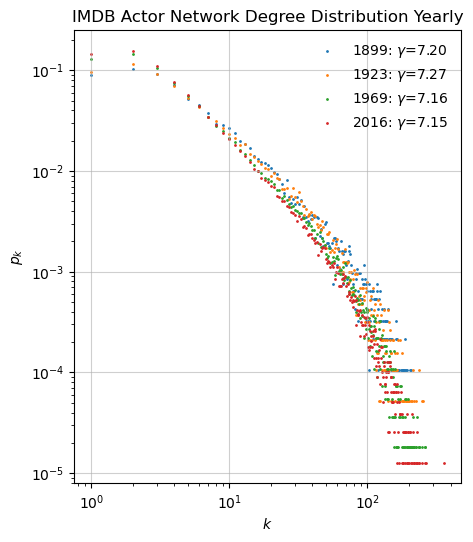

In [44]:
# 1830, 1876, 1923, 1969, 2016
years = [1899, 1923, 1969, 2016]
def get_degree_dist_before(G, year):
    sub_vs = G.vs.select(birthYear_le = year)
    sub_g = G.subgraph(sub_vs[:])
    sub_gamma = powerlaw.Fit(sub_g.degree(), discrete=True).alpha
    sub_dist = dict2np(Counter(sub_g.degree()))
    return sub_dist, sub_gamma, len(sub_vs)

dists = []
gammas = []
Ns = []
for year in years:
    sub_dist, sub_gamma, N = get_degree_dist_before(ag, year)
    dists.append(sub_dist)
    gammas.append(sub_gamma)
    Ns.append(N)

draw_degree_dist_timely(dists, gammas, Ns, years, 'IMDB Actor Network')

### Dynamic display

In [45]:
%matplotlib inline
import matplotlib.animation as animation
from IPython import display
plt.ioff()
plt.rcParams['animation.ffmpeg_path'] = '/opt/homebrew/Cellar/ffmpeg/5.1.2/bin/ffmpeg' # change to your ffmpeg path

fig, ax = plt.subplots(figsize=(5,6), dpi=100)
txt_title = ax.set_title('')
ax.set_xlabel('$k_{in}$')
ax.set_ylabel('$p_k$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1, 2000)
ax.set_ylim(10e-7, 1)
ax.grid(alpha=0.6)
xdata, ydata = [], []
ln, = ax.plot([], [], 'r.', ms=2, label='birth')
txt_label = plt.legend(loc='lower left')
        
def update(year):
    sub_vs = ag.vs.select(birthYear_le = year)
    sub_g = ag.subgraph(sub_vs)
    sub_dist = dict2np(Counter(sub_g.degree()))
    xdata = sub_dist[:,0]
    ydata = sub_dist[:,1] / len(sub_vs)
    ln.set_data(xdata, ydata)  
    txt_title.set_text(f'Evolution of Degree in IMDB Actors\n(Y:{year} N:{len(sub_vs)})')
    txt_label.get_texts()[0].set_text(f'Birth:{int(year)}')
    return ln,

years = range(1830, 2016, 1)
anim = animation.FuncAnimation(fig, update, years, blit=True)
video = anim.to_html5_video() # anim.save('path/to/video.file')
html = display.HTML(video)
display.display(html)
plt.close() 

## ~Shortest-path-length Distribution~

In [ ]:
# ag_length_hist = ag.path_length_hist(directed=False)
# ba_length_hist = ba.path_length_hist(directed=False)
# er_length_hist = er.path_length_hist(directed=False)

## Summary 

In [399]:
summary = pd.DataFrame(np.ones((3,8)), columns = ['Network', 'N', 'L', '⟨k⟩', '⟨k²⟩', 'σ', 'γ', 'Density'])
summary.Network = ['Actor-Network', 'Barabási–Albert', 'Erdős–Rényi']
summary.N = [len(ag.vs), len(ba.vs), len(er.vs)]
summary.L = [len(ag.es), len(ba.es), len(er.es)]
summary.loc[:, '⟨k⟩']  = [np.mean(i) for i in [ag.degree(), ba.degree(), er.degree()]]
summary.loc[:, '⟨k²⟩'] = [np.square(i).mean() for i in [ag.degree(), ba.degree(), er.degree()]]
summary.loc[:, 'σ'] = [np.std(ag.degree()), np.std(ba.degree()), np.std(er.degree())]
summary.loc[:, 'γ'] = [ag_gamma, ba_gamma, er_gamma]
summary.Density = [ag.density(), ba.density(), er.density()]  
# summary.Diameter = [mg.diameter(directed=False), ba.diameter(False), er.diameter(Fales)]   # 'Diameter'
summary

,Network,N,L,⟨k⟩,⟨k²⟩,σ,γ,Density
0,Actor-Network,274067,1091586,7.965833,305.240799,15.549479,2.234163,0.000029
1,Barabási–Albert,274067,1096258,7.999927,183.683012,10.940026,3.145136,0.000029
2,Erdős–Rényi,274067,1091586,7.965833,71.430563,2.824193,11.200499,0.000029


# Other Experiments

## Random network with growing p

In [379]:
%matplotlib inline
import matplotlib.animation as animation
from IPython import display
plt.ioff()
plt.rcParams['animation.ffmpeg_path'] = '/opt/homebrew/Cellar/ffmpeg/5.1.2/bin/ffmpeg' # change to your ffmpeg path

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,6), dpi=100)
ax1.set_title('p and d in Random Network\n(N=100)')
ax1.set_xlim(0, 1.0)
ax1.set_ylim(0, 100)
ax1.grid(alpha=0.6)
ax2.set_title('p and L in Random Network\n(N=100)')
ax2.set_xlim(0, 1.0)
ax2.set_ylim(0, 5000)
ax2.grid(alpha=0.6)
pdata, ddata, ldata = [], [], []
ln1, = ax1.plot([], [], 'ro', ms=5)
ln2, = ax2.plot([], [], 'bo', ms=5)
def update(p):
    grand = ig.Graph.Erdos_Renyi(n=100, p=p, directed=False, loops=False)
    d = np.mean(grand.degree())
    pdata.append(p)
    ddata.append(d)
    ldata.append(len(grand.es))
    ln1.set_data(pdata, ddata)
    ln2.set_data(pdata, ldata)
    return ln1, ln2,
    
anim = animation.FuncAnimation(fig, update, np.linspace(0, 1, 20), blit=True)
video = anim.to_html5_video() # anim.save('path/to/video.file')
html = display.HTML(video)
display.display(html)
plt.close() 

## Generate Power-Law graph with different $\gamma$ s

### For the movie network

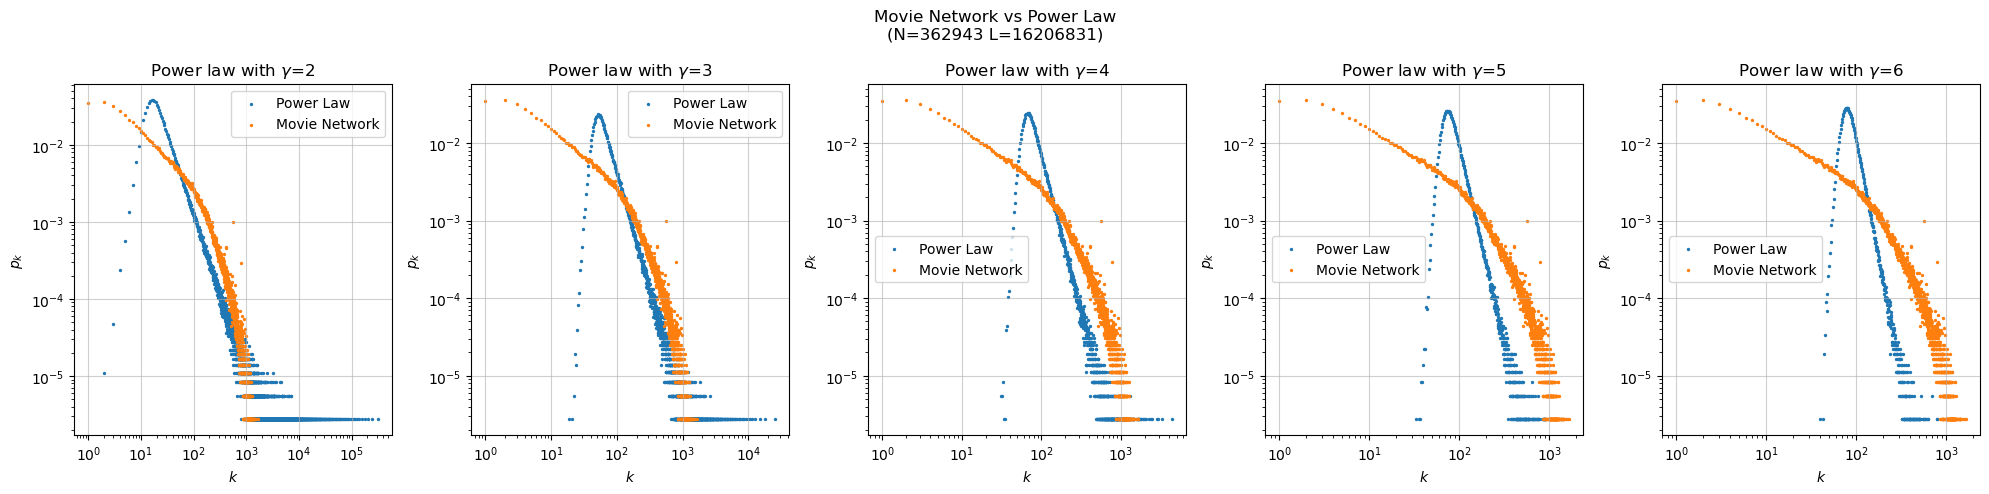

In [27]:
# Load Checkpoint
mg = ig.Graph.Read_Pickle('./imdb/network/imdb.movie.ig.pickle')
mg = mg.connected_components().giant()
mg_gamma = powerlaw.Fit(mg.degree(), discrete=True).alpha
mg_dist = dict2np(Counter(mg.degree()))
N, L = len(mg.vs), len(mg.es)
dists = [mg_dist, ]
for i in tqdm([2,3,4,5,6]):
    pl = ig.Graph.Static_Power_Law(N, L, exponent_out=i, exponent_in=-1, loops=False, multiple=False, finite_size_correction=True)
    # pl_gamma = ig.statistics.power_law_fit(pl.degree(), method='discrete').alpha
    pl_gamma = powerlaw.Fit(pl.degree(), discrete=True).alpha
    pl_dist = dict2np(Counter(pl.degree()))
    dists.append(pl_dist)
    
draw_powerlaws(dists, N, L, 'Movie Network')

### For the actor network

Calculating best minimal value for power law fit


  0%|          | 0/5 [00:00<?, ?it/s]

Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


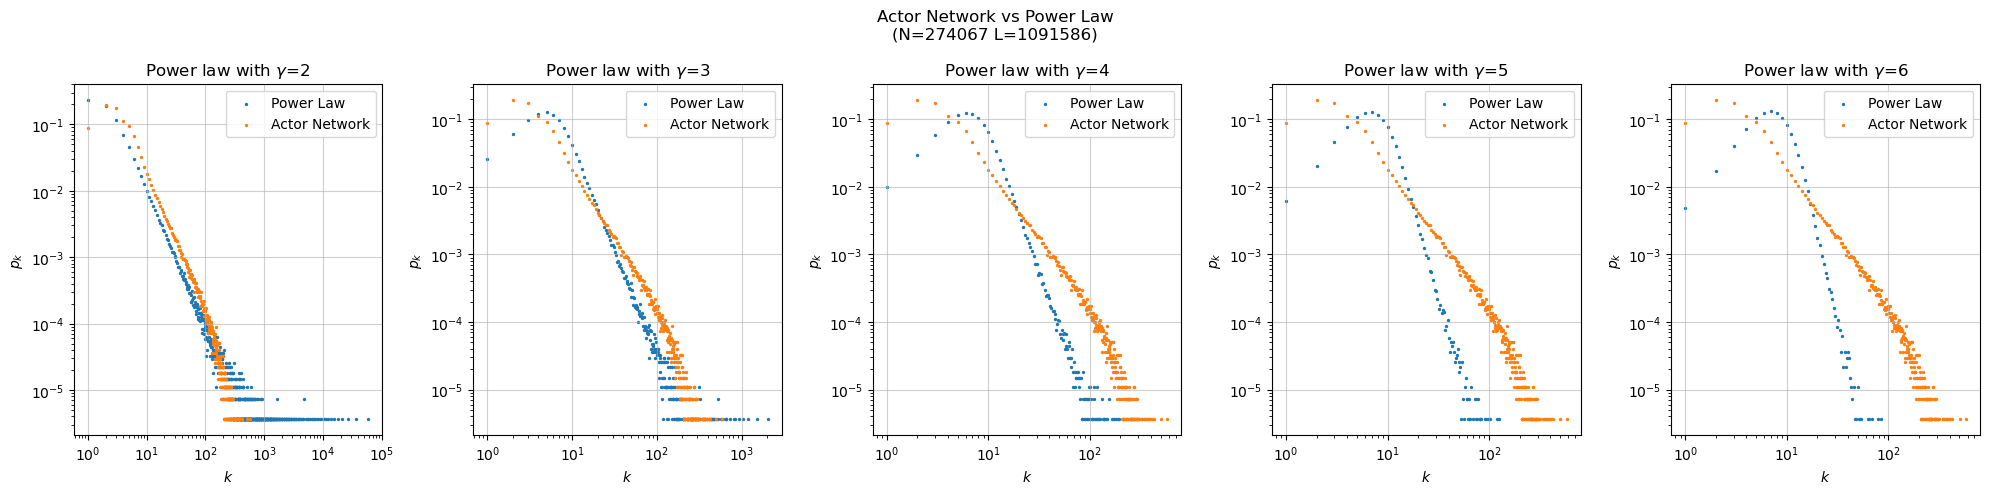

In [29]:
# Load Checkpoint
ag = ig.Graph.Read_Pickle('./imdb/network/imdb.actor.ig.pickle')
ag = ag.connected_components().giant()
ag_gamma = powerlaw.Fit(ag.degree(), discrete=True).alpha
ag_dist = dict2np(Counter(ag.degree()))
N, L = len(ag.vs), len(ag.es)
dists = [ag_dist, ]
for i in tqdm([2,3,4,5,6]):
    pl = ig.Graph.Static_Power_Law(N, L, exponent_out=i, exponent_in=-1, loops=False, multiple=False, finite_size_correction=True)
    # pl_gamma = ig.statistics.power_law_fit(pl.degree(), method='discrete').alpha
    pl_gamma = powerlaw.Fit(pl.degree(), discrete=True).alpha
    pl_dist = dict2np(Counter(pl.degree()))
    dists.append(pl_dist)
    
draw_powerlaws(dists, N, L, 'Actor Network')